In [288]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob

In [289]:
# Load data
def load_data(data_path):
    if os.path.isfile(data_path):
        data = np.genfromtxt(data_path, names=True, delimiter=",")
        return data
    else:
        return None
    
def load_csv_files(directory, data_type):
    csv_files = glob.glob(os.path.join(directory, '*' + data_type + '.csv'))

    data_dict = {}

    for csv_file in csv_files:
        data = load_data(csv_file)
        label = os.path.splitext(os.path.basename(csv_file))[0]
        label = label[:label.rfind(data_type)-1]
        data_dict[label] = data

    if len(data_dict) == 0:
        print("Failed to load any data!")

    return data_dict

def filter_nan(data_dict):
    for label, data in data_dict.items():
        data_clean = data[~np.isnan(data["stability"])]
        count_cleaned = len(data["stability"]) - len(data_clean["stability"])
        if count_cleaned > 0:
            print(f"[WARNING] {label}: Removed {count_cleaned} entries with nan stability")
            data_dict[label] = data_clean
    
folder = "../../data"
data_dict_imu = load_csv_files(folder, "imu")
data_dict_stability = load_csv_files(folder, "stability")
filter_nan(data_dict_stability)
print(f"Loaded {len(data_dict_imu)} imu datasets.")
for label, data_imu in data_dict_imu.items():
    print(label)
print(f"Loaded {len(data_dict_stability)} stability datasets.")
for label, data_imu in data_dict_stability.items():
    print(label)

Loaded 3 imu datasets.
3_rough_trial-0
teleop_trial-0
whole_body_assistance_trial-0
Loaded 3 stability datasets.
whole_body_assistance_trial-0
3_rough_trial-0
teleop_trial-0


In [290]:
def compute_binned_stability(travelled_distance, stability, bin_size):
    # Define bin edges
    min_distance = travelled_distance.min()
    max_distance = travelled_distance.max()
    bins = np.arange(min_distance, max_distance + bin_size, bin_size)
    # print(bins)

    # Assign each travelled_distance value to a bin
    bin_indices = np.digitize(travelled_distance, bins)

    # Calculate the average stability for each bin
    binned_stability = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        indices = np.where(bin_indices == i)[0]
        if indices.size > 0:
            binned_stability[i-1] = np.mean(stability[indices])
        else:
            print(f"[WARNING] Bin ({bins[i-1]},{bins[i]}) is empty")

    bin_values = bins[0:len(bins)-1] + bin_size / 2.0

    # The binned_stability dictionary now contains the average stability values for each bin
    # print(bin_values)
    # print(binned_stability)
    # for bin_range, avg_stability in binned_stability.items():
    #     print(f"Bin {bin_range}: Average Stability = {avg_stability}")

    return bin_values, binned_stability

def compute_moving_average_over_distance(travelled_distance, stability, window_distance=1.0):
    # Initialize the list to hold the running averages
    running_averages = np.empty_like(stability)

    # Compute running average with a 1m window
    for i in range(len(travelled_distance)):
        # Determine the start and end of the window
        start_distance = travelled_distance[i] - window_distance / 2
        end_distance = travelled_distance[i] + window_distance / 2
        
        # Find indices where distances fall within the window
        window_indices = np.where((travelled_distance >= start_distance) & (travelled_distance <= end_distance))[0]
        
        # Compute the average stability for these indices
        running_averages[i] = np.mean(stability[window_indices])
    return running_averages

def moving_average(data, size):
    window = np.ones(int(size)) / float(size)
    return np.convolve(data, window, 'same')




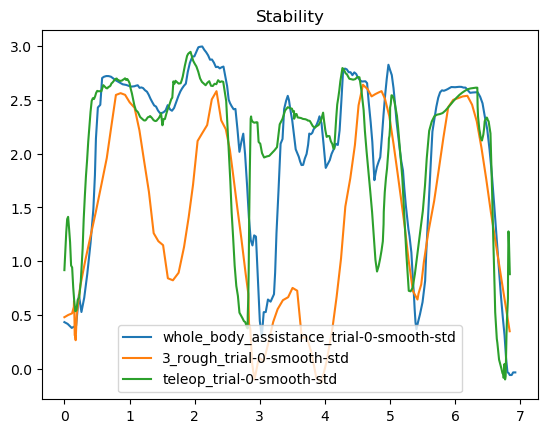

In [291]:
# Stability plot
# Raw relative probability per sample
fig, ax = plt.subplots()
ax.title.set_text("Stability")
for label, data in data_dict_stability.items():

    # bin_size = 0.15
    # bin_values, binned_stability = compute_binned_stability(data["travelled_distance"], data["stability"], bin_size)
    # ax.bar(bin_values, binned_stability, width=bin_size)


    # ax.plot(data["travelled_distance"], data["stability"], label=label)
    
    # smoothed_stability = compute_moving_average_over_distance(data["travelled_distance"], data["stability"], window_distance=0.25)
    # ax.plot(data["travelled_distance"], smoothed_stability, label=label + "-smooth")
    smoothed_stability_standard = moving_average(data["stability"], size=9)
    ax.plot(data["travelled_distance"], smoothed_stability_standard, label=label + "-smooth-std")

ax.legend()
plt.show()

In [292]:
def compute_statistics(array, label: str):
    avg = np.mean(array)
    sum = np.sum(array)
    maximum = np.max(array)
    print(f" -- Avg. {label}: {avg:.2f}, Acc. {label}: {sum:.2f}, Max. {label}: {maximum:.2f}") 

def compute_shock(acc_x, acc_y, acc_z):
    calibration = 0.69
    gravity = 9.81
    shock = np.abs(acc_x) + np.abs(acc_y) + np.abs(acc_z) - gravity - calibration
    shock = np.maximum(shock, 0.0)
    shock = shock
    return shock

def compute_swing(vel_x, vel_y):
    calibration = 0.27
    swing = np.abs(vel_x) + np.abs(vel_y) - calibration
    swing = np.maximum(swing, 0.0)
    swing = swing
    return swing

# Compute trial metrics
def compute_metrics(data_imu, data_stability):
    # time
    duration = max(data_imu["time"][-1], data_stability["time"][-1])
    print(f" -- Duration: {duration:.2f}s")

    # Average stability
    avg_stability = np.mean(data_stability["stability"])
    _, binned_stability = compute_binned_stability(data_stability["travelled_distance"], data_stability["stability"], 0.12)
    avg_binned_stability = np.mean(binned_stability)
    # smoothed_stability = compute_moving_average_over_distance(data_stability["travelled_distance"], data_stability["stability"], window_distance=1.0)
    smoothed_stability = moving_average(data_stability["stability"], size=5)
    avg_smoothed_stability = np.mean(smoothed_stability)
    print(f" -- Avg. stability: {avg_stability:.2f}, avg. binned stability: {avg_binned_stability:.2f}, avg. smoothed stability: {avg_smoothed_stability:.2f}")

    # Locomotion roughness
    shock = compute_shock(data_imu["linear_acceleration_x"], data_imu["linear_acceleration_y"], data_imu["linear_acceleration_z"])
    compute_statistics(shock, "shock")

    swing = compute_swing(data_imu["angular_velocity_x"], data_imu["angular_velocity_y"])
    compute_statistics(swing, "swing")


for label, data_imu in data_dict_imu.items():
    print(f"Trial {label} metrics:")
    data_stability = data_dict_stability[label]
    compute_metrics(data_imu, data_stability) 

Trial 3_rough_trial-0 metrics:
 -- Duration: 13.14s
 -- Avg. stability: 1.36, avg. binned stability: 1.51, avg. smoothed stability: 1.35
 -- Avg. shock: 3.79, Acc. shock: 2492.61, Max. shock: 70.10
 -- Avg. swing: 0.34, Acc. swing: 226.23, Max. swing: 2.08
Trial teleop_trial-0 metrics:
 -- Duration: 44.44s
 -- Avg. stability: 1.99, avg. binned stability: 2.10, avg. smoothed stability: 1.99
 -- Avg. shock: 1.25, Acc. shock: 2783.14, Max. shock: 41.62
 -- Avg. swing: 0.05, Acc. swing: 100.77, Max. swing: 1.63
Trial whole_body_assistance_trial-0 metrics:
 -- Duration: 28.92s
 -- Avg. stability: 2.03, avg. binned stability: 2.04, avg. smoothed stability: 2.03
 -- Avg. shock: 2.20, Acc. shock: 3185.70, Max. shock: 61.55
 -- Avg. swing: 0.14, Acc. swing: 207.33, Max. swing: 2.24


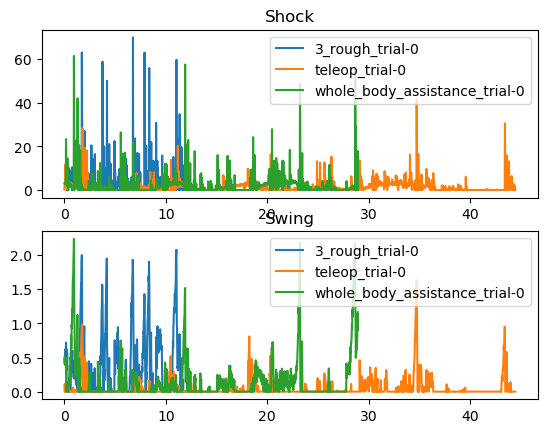

In [293]:
fig, axs = plt.subplots(2, 1)
axs[0].title.set_text("Shock")
axs[1].title.set_text("Swing")
for label, data in data_dict_imu.items():
    gravity = 9.81
    shock = compute_shock(data["linear_acceleration_x"], data["linear_acceleration_y"], data["linear_acceleration_z"])
    axs[0].plot(data["time"], shock, label=label)

    swing = compute_swing(data["angular_velocity_x"], data["angular_velocity_y"])
    swing = np.maximum(swing, 0.0)

    axs[1].plot(data["time"], swing, label=label)
    # axs[1].plot(data["time"], data["angular_velocity_z"])
axs[0].legend()
axs[1].legend()


In [294]:
#